In [3]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image 
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets , transforms , models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm


In [4]:
data_path = 'C:\\Users\\umr81\\OneDrive\\Documents\\Lung Disease project\\Data'

In [5]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_of_file(dir_name):
    files_list=os.listdir(dir_name)
    return files_list

file_list_normal_train=get_list_of_file(data_path+'/train/'+class_name[0])
file_list_pneumonia_train=get_list_of_file(data_path+'/train/'+class_name[1])
file_list_normal_test=get_list_of_file(data_path+'/test/'+class_name[0])
file_list_pneumonia_test=get_list_of_file(data_path+'/test/'+class_name[1])

In [6]:
print("Number of normal images in training set: ",len(file_list_normal_train))
print("Number of pneumonia images in training set: ",len(file_list_pneumonia_train))
print("Number of pneumonia images in test set: ",len(file_list_normal_test))
print("Number of pneumonia images in test set: ",len(file_list_pneumonia_test))

Number of normal images in training set:  1266
Number of pneumonia images in training set:  3418
Number of pneumonia images in test set:  317
Number of pneumonia images in test set:  855


(2226, 2442, 3)


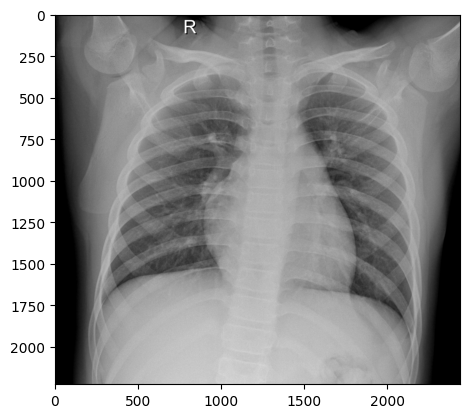

In [7]:
rand_img_no=random.randint(0,len(file_list_normal_train))
img = data_path+'/train/NORMAL/'+file_list_normal_train[rand_img_no]
print(plt.imread(img).shape)
img=mpimg.imread(img)
plt.imshow(img)

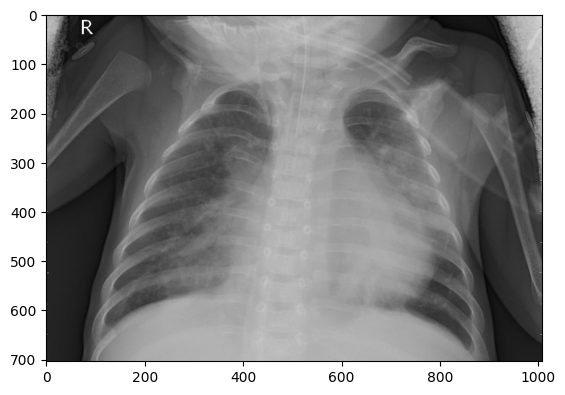

In [8]:
random_index=np.random.randint(0,len(file_list_pneumonia_train))
im=data_path+'/train/PNEUMONIA/'+file_list_pneumonia_train[random_index]
im=mpimg.imread(im)
plt.imshow(im)

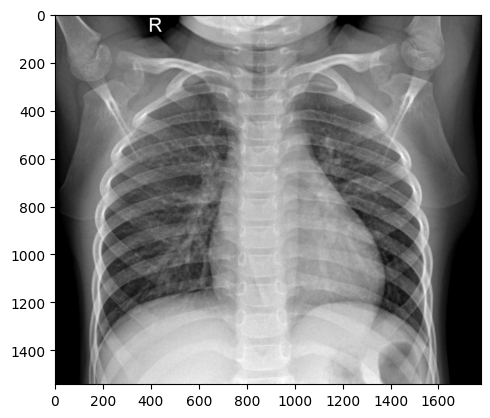

In [9]:
normal_index=np.random.randint(0,len(file_list_normal_test))
im=data_path+'/test/NORMAL/'+file_list_normal_test[normal_index]
im=mpimg.imread(im)
plt.imshow(im)

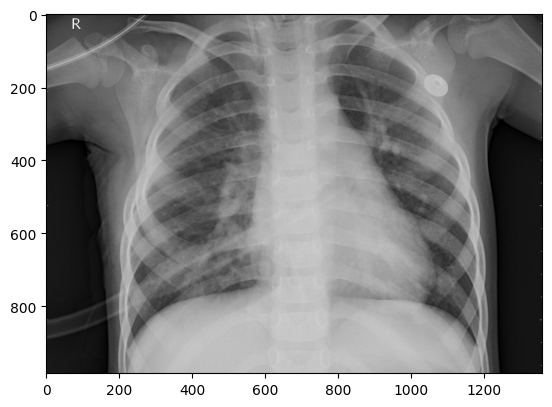

In [10]:
random_index=np.random.randint(0,len(file_list_pneumonia_test))
im=data_path+'/test/PNEUMONIA/'+file_list_pneumonia_test[random_index]
im=mpimg.imread(im)
plt.imshow(im)

In [11]:
train_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10,contrast=0.1,saturation=0.10,hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [12]:
train_data=datasets.ImageFolder(os.path.join(data_path,'train'),transform=train_transform)
test_data=datasets.ImageFolder(os.path.join(data_path,'test'),transform=test_transform)
train_loader=DataLoader(train_data,batch_size=2,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_data,batch_size=2,shuffle=False,pin_memory=True)
num_classes=train_data.classes
print(num_classes)
print('len of training data:',len(train_data))
print('len of test data:',len(test_data))

['NORMAL', 'PNEUMONIA']
len of training data: 4684
len of test data: 1172


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.convolution_block1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=8,kernel_size=(3,3),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pooling1=nn.MaxPool2d((2,2))
        self.convolution_block2=nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=20,kernel_size=(3,3),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling2=nn.MaxPool2d((2,2))
        self.convolution_block3=nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.pooling3=nn.MaxPool2d((2,2))
        self.convolution_block4=nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
      
        self.convolution_block5=nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=32,kernel_size=(1,1),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
      
        self.convolution_block6=nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(3,3),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
       
        self.convolution_block7=nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(1,1),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
    
        self.convolution_block8=nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels=14,kernel_size=(3,3),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )

        self.convolution_block9=nn.Sequential(
            nn.Conv2d(in_channels=14,out_channels=16,kernel_size=(3,3),padding=0,bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        #output BLock
        self.gap=nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.fc=nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=2,kernel_size=(4,4),padding=0,bias=True),
        )
    def forward(self,x):
        x=self.convolution_block1(x)
        x=self.pooling1(x)
        x=self.convolution_block2(x)
        x=self.pooling2(x)
        x=self.convolution_block3(x)
        x=self.pooling3(x)
        x=self.convolution_block4(x)
        x=self.convolution_block5(x)
        x=self.convolution_block6(x)
        x=self.convolution_block7(x)
        x=self.convolution_block8(x)
        x=self.convolution_block9(x)
        x=self.gap(x)
        x=self.fc(x)
        x=x.view(-1,2)
        return F.sigmoid(x)
     

In [14]:
use_cuda=torch.cuda.is_available()
device=torch.device('cuda' if use_cuda else 'cpu')
print('available processor {}'.format(device))
model=Net().to(device)
summary(model,input_size=(3,224,224))

available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 20, 109, 109]           1,460
              ReLU-6         [-1, 20, 109, 109]               0
       BatchNorm2d-7         [-1, 20, 109, 109]              40
         MaxPool2d-8           [-1, 20, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             210
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 20, 25, 25]           1,820
             Re

In [15]:
train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]
def train(model,device,train_loader,optimizer,epoch):   
    model.train()
    pbar=tqdm(train_loader)
    correct=0
    processed=0
    train_loss=0
    for batch_idx,(data,target) in enumerate(pbar):
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        y_pred=model(data)
        loss=F.nll_loss(y_pred,target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred=y_pred.argmax(dim=1,keepdim=True)
        correct+=pred.eq(target.view_as(pred)).sum().item()
        processed+=len(data)
        pbar.set_description(desc='Train epoch {} Loss={:.4f} Accuracy={:.4f}'.format(epoch,loss.item(),100*correct/processed))
        train_acc.append(100*correct/processed)
def test(model,device,test_loader):
    model.eval()
    test_loss=0
    correct=0
    with torch.no_grad():
        for data,target in test_loader:
            data,target=data.to(device),target.to(device)
            output=model(data)
            test_loss+=F.nll_loss(output,target,reduction='sum').item()
            pred=output.argmax(dim=1,keepdim=True)
            correct+=pred.eq(target.view_as(pred)).sum().item()
    test_loss/=len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss,correct,len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model=Net().to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.8)
scheduler=StepLR(optimizer,step_size=6,gamma=0.5)
EPOCHS=4
for epoch in range(EPOCHS):
    print('EPOCH:',epoch)
    train(model,device,train_loader,optimizer,epoch)
    scheduler.step()
    print('current learning rate:',optimizer.state_dict()['param_groups'][0]['lr'] )
    test(model,device,test_loader)

EPOCH: 0


  0%|          | 0/2342 [00:00<?, ?it/s]c:\Users\umr81\OneDrive\Documents\Lung Disease project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train epoch 0 Loss=-0.9988 Accuracy=77.1990: 100%|██████████| 2342/2342 [03:32<00:00, 11.04it/s]


current learning rate: 0.01

Test set: Average loss: -0.9963, Accuracy: 863/1172 (73.6348%)

EPOCH: 1


Train epoch 1 Loss=-1.0000 Accuracy=76.0034: 100%|██████████| 2342/2342 [02:50<00:00, 13.70it/s]


current learning rate: 0.01

Test set: Average loss: -0.9975, Accuracy: 938/1172 (80.0341%)

EPOCH: 2


Train epoch 2 Loss=-1.0000 Accuracy=76.1529: 100%|██████████| 2342/2342 [03:50<00:00, 10.14it/s]


current learning rate: 0.01

Test set: Average loss: -0.9988, Accuracy: 900/1172 (76.7918%)

EPOCH: 3


Train epoch 3 Loss=-1.0000 Accuracy=76.4091: 100%|██████████| 2342/2342 [02:58<00:00, 13.14it/s]


current learning rate: 0.01

Test set: Average loss: -0.9960, Accuracy: 946/1172 (80.7167%)



In [38]:
for epoch in range(2):
    print('EPOCH:',epoch)
    train(model,device,train_loader,optimizer,epoch)
    scheduler.step()
    print('current learning rate:',optimizer.state_dict()['param_groups'][0]['lr'] )
    test(model,device,test_loader)

EPOCH: 0


Train epoch 0 Loss=-1.0000 Accuracy=78.3945: 100%|██████████| 2342/2342 [04:44<00:00,  8.24it/s]


current learning rate: 0.01

Test set: Average loss: -0.9939, Accuracy: 961/1172 (81.9966%)

EPOCH: 1


Train epoch 1 Loss=-1.0000 Accuracy=77.4765: 100%|██████████| 2342/2342 [04:33<00:00,  8.56it/s]


current learning rate: 0.005

Test set: Average loss: -0.9929, Accuracy: 965/1172 (82.3379%)



In [17]:
import torch
torch.save(model.state_dict(),'xray_model.pth')

In [18]:
# Save model one directory up from the notebook folder
torch.save(model.state_dict(), '../xray_model.pth')